In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
class FiniteDifferenceScheme:
    """ Class for pricing options using the binomial tree model
    Inputs:
        S_0 - initial stock price
        K - strike price
        r - risk-free interest rate
        T - time to maturity
        sigma - volatility
        N - number of time steps
    """
    def __init__(self, S0, Smax, K, r, T, sigma, n, m):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.n = n
        self.m = m
        self.dt = self.T / self.n
        self.Smax = Smax
        self.dS = self.Smax / self.m

    def d1(self, S, t):
        return ((np.log(S / self.K) + (self.r + 0.5 * self.sigma ** 2) * (self.T-t))/(self.sigma * np.sqrt(self.T-t)))
    
    def d2(self, S, t):
        return self.d1(S, t) - self.sigma * np.sqrt(self.T-t)

    def black_scholes(self, option_type, S, t):
        if option_type == 'call':
            return self.S0 * norm.cdf(self.d1(S, t)) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2(S, t))
        elif option_type == 'put':
            return self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2(S, t)) - self.S0 * norm.cdf(-self.d1(S, t))
    
    def explicit(self, i):
        a = 1/2 * self.dt * (-self.r * i + (self.sigma * i)**2)
        b = 1 - self.dt * (self.r + (self.sigma * i)**2)
        c = 1/2 * self.dt * (self.r * i + (self.sigma * i)**2)
        return a, b, c
    
    def implicit(self, i):
        a = 1/2 * self.dt * (self.r * i - (self.sigma * i)**2)
        b = 1 + self.dt * (self.r + (self.sigma * i)**2)
        c = -1/2 * self.dt * (self.r * i + (self.sigma * i)**2)
        return a, b, c
    
    def stock_matrix(self, option_type, method):
        F = np.zeros((self.m+1, self.n+1))
        if option_type == 'call':
            for i in range(F.shape[0]):
                F[i, self.n] = np.maximum(i * self.dS - self.K, 0)
            for j in range(F.shape[1]):
                F[-1, j] = self.Smax - self.K * np.exp(-self.r * (self.n - j) * self.dt)
        if option_type == 'put':
            for i in range(F.shape[0]):
                F[i, self.n] = np.maximum(self.K - i * self.dS, 0)
            for j in range(F.shape[1]):
                F[0, j] = self.K * np.exp(-self.r * (self.n - j) * self.dt)
        if method == 'explicit':
            a_list, b_list, c_list = [], [], [] 
            for i in range(F.shape[0]):
                a, b, c = self.explicit(i)
                a_list.append(a)
                b_list.append(b)
                c_list.append(c)
            for j in range(F.shape[1] - 2, -1, -1):
                for i in range(F.shape[0] - 2, 0, -1):
                    F[i, j] = a_list[i] * F[i-1, j+1] + b_list[i] * F[i, j+1] + c_list[i] * F[i+1, j+1]
        if method == 'implicit':
            a_list, b_list, c_list = [], [], [] 
            for i in range(1, F.shape[0]- 1):
                a, b, c = self.implicit(i)
                if i > 1:
                    a_list.append(a)
                b_list.append(b)
                if i < F.shape[0] - 2:
                    c_list.append(c)
            A = np.diag(a_list, -1) + np.diag(b_list) + np.diag(c_list, 1)
            A_inv = np.linalg.inv(A)
            for j in range(F.shape[1] - 1, 0, -1):
                F[1:-1, j-1] = A_inv @ F[1:-1, j]
        if method == 'CN':
            a_list_ex, b_list_ex, c_list_ex = [], [], [] 
            a_list_im, b_list_im, c_list_im = [], [], []
            for i in range(1, F.shape[0]- 1):
                a_ex, b_ex, c_ex = self.explicit(i) #*
                a_im, b_im, c_im = self.implicit(i)
                a_list_im.append(a_im)
                b_list_im.append(b_im+1)
                c_list_im.append(c_im)
                a_list_ex.append(a_ex)
                b_list_ex.append(b_ex+1)
                c_list_ex.append(c_ex)
            rows = len(a_list_ex)
            cols = len(a_list_ex) + 2
            A1, A2 = np.zeros((rows, cols)), np.zeros((rows, cols))
            for i in range(len(a_list_ex)):
                A1[i, i], A1[i, i + 1], A1[i, i + 2] = a_list_im[i], b_list_im[i], c_list_im[i]
                A2[i, i], A2[i, i + 1], A2[i, i + 2] = a_list_ex[i], b_list_ex[i], c_list_ex[i]
            A1_pinv = np.linalg.pinv(A1)
            for j in range(F.shape[1] - 1, 0, -1):
                F[1:-1, j-1] = (A1_pinv @ (A2 @ F[:, j]))[1:-1]

        return F

    def price(self, option_type, method):
        F = self.stock_matrix(option_type, method)
        return np.interp(self.S0, np.linspace(0, self.Smax, self.m+1), F[:,0])

In [3]:
def plot_option_price(S0, Smax, K, r, T, sigma, ns, ms, option_type):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    for i in range(len(ms)):
        explicit, implicit, cn = [], [], []
        for n in ns:
            FDS = FiniteDifferenceScheme(S0, Smax, K, r, T, sigma, n, ms[i])
            if len(cn) == 0:
                bs = FDS.black_scholes(option_type, S0, 0)
            explicit.append(FDS.price(option_type, 'explicit'))
            implicit.append(FDS.price(option_type, 'implicit'))
            cn.append(FDS.price(option_type, 'CN'))
        axs[i].set_title(f'European Vanilla {option_type.capitalize()} Option $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, m={ms[i]}', fontsize=12)
        axs[i].plot(ns, explicit, label = 'explicit scheme', color = 'royalblue', marker='o', markersize=3, zorder=1)
        axs[i].plot(ns, implicit, label = 'implicit scheme', color = 'red', marker='o', markersize=3, zorder=1)
        axs[i].plot(ns, cn, label = 'Crank-Nicolson scheme', color = 'lime', marker='o', markersize=3, zorder=1)
        axs[i].hlines(bs, xmin=ns[0], xmax=ns[-1], label = 'Black-Scholes', color = 'purple', zorder=2)
        axs[i].set_xlabel('Number of steps', fontsize=12)
        axs[i].set_ylabel('Option price', fontsize=12)
        axs[i].tick_params(axis='x', labelsize=12)
        axs[i].tick_params(axis='y', labelsize=12)
        axs[i].set_ylim(bs - 0.5, bs + 0.5)
        axs[i].legend(loc = 'upper left')
        axs[i].grid()
    plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\patry\AppData\Local\Temp\ipykernel_19248\3465339136.py:12: SyntaxWarning: invalid escape sequence '\s'
  axs[i].set_title(f'European Vanilla {option_type.capitalize()} Option $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, m={ms[i]}', fontsize=12)


In [4]:
S0 = 100
Smax = 300
sigma = 0.2
r = 0.05
T = 1
K = 100

In [5]:
ns = np.arange(5, 101, 1)
ms = [30, 60, 120]

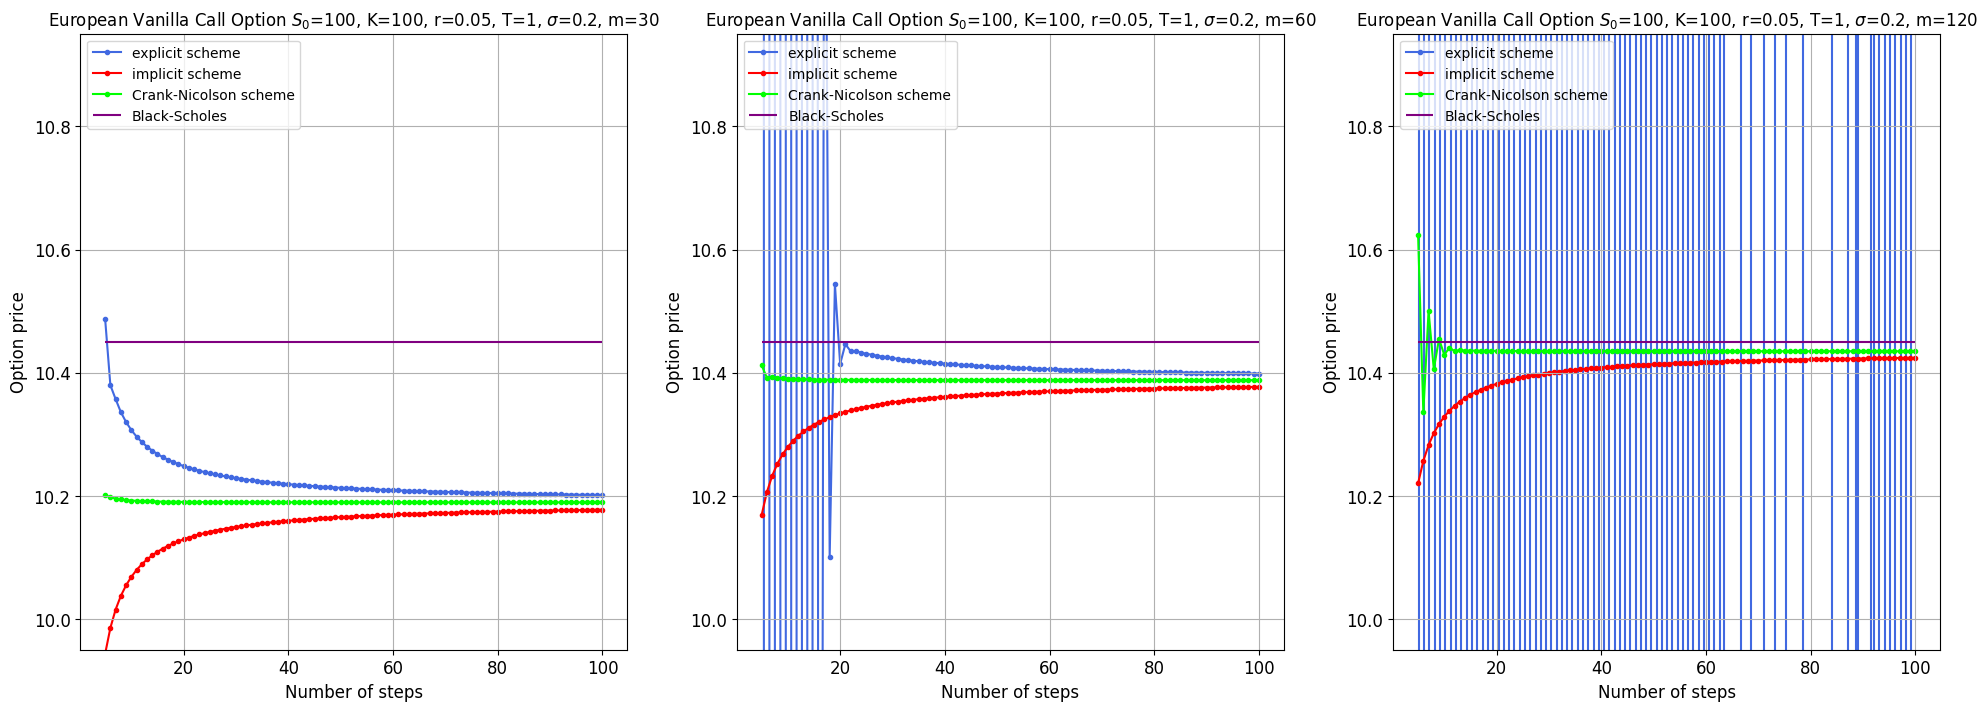

In [6]:
plot_option_price(S0, Smax, K, r, T, sigma, ns, ms, 'call')

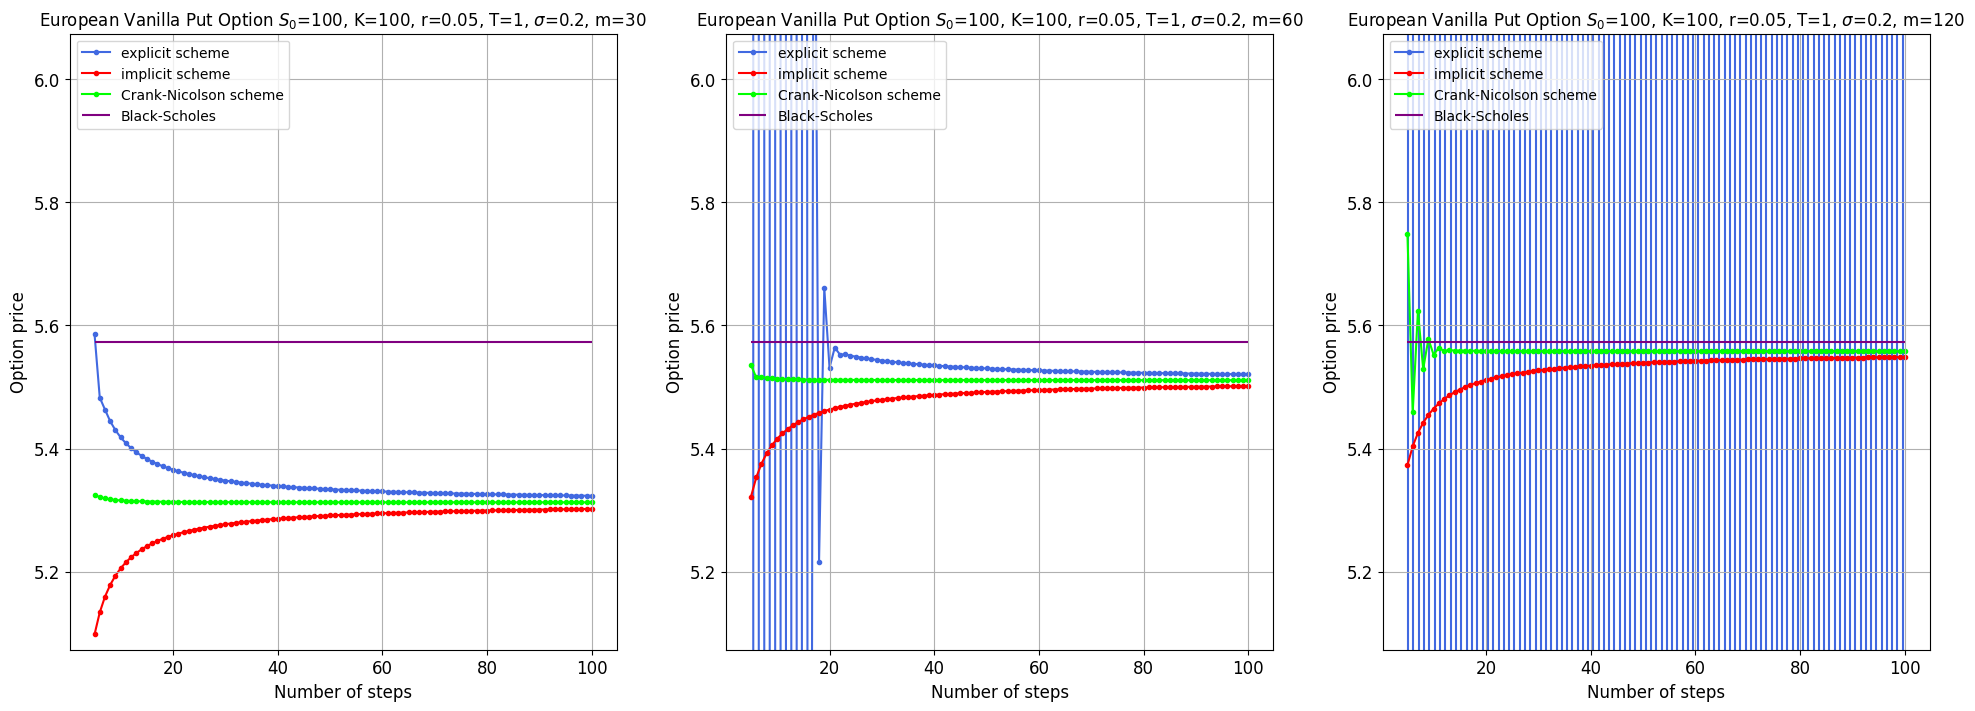

In [7]:
plot_option_price(S0, Smax, K, r, T, sigma, ns, ms, 'put')

In [ ]:
def option_price_change(S0, Smax, K, r, T, sigma, n, ms, option_type, abs = False):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    for i in range(len(ms)):
        explicit, implicit, cn, bs = [], [], [], []
        if type(Smax) is list:
            change = Smax
            pom = 'maximum s'
            axs[i].set_title(f'European {option_type.capitalize()} Option $S_0$={S0}, K={K}, n=100, r={r}, T={T}, $\sigma$={sigma}, m={ms[i]}', fontsize=12)
            axs[i].set_xlabel(f'Change of {pom.capitalize()}', fontsize=12)
        elif type(T) is list:
            change = T
            pom = 'time at maturity'
            axs[i].set_title(f"European {option_type.capitalize()} Option $S_0$={S0}, $S_m$={Smax}, K={K}, n=100, r={r}, $\sigma$={sigma}, m={ms[i]}", fontsize=12)
            axs[i].set_xlabel(f'Change of {pom.capitalize()}', fontsize=12)
        elif type(sigma) is list:
            change = sigma
            pom = 'volatility'
            axs[i].set_title(f"European {option_type.capitalize()} Option $S_0$={S0}, $S_m$={Smax}, K={K}, n=100, r={r}, T={T}, m={ms[i]}", fontsize=12)
            axs[i].set_xlabel(f'Change of {pom.capitalize()}', fontsize=12)
        for j in change:
            if type(Smax) is list:
                FDS = FiniteDifferenceScheme(S0, j, K, r, T, sigma, n, ms[i])
            elif type(T) is list:
                FDS = FiniteDifferenceScheme(S0, Smax, K, r, j, sigma, n, ms[i])
            elif type(sigma) is list:
                FDS = FiniteDifferenceScheme(S0, Smax, K, r, T, j, n, ms[i])
            if abs == False:
                bs.append(FDS.black_scholes(option_type, S0, 0))
                explicit.append(FDS.price(option_type, 'explicit'))
                implicit.append(FDS.price(option_type, 'implicit'))
                cn.append(FDS.price(option_type, 'CN'))
            else:
                bs = FDS.black_scholes(option_type, S0, 0)
                explicit.append(np.absolute(bs - FDS.price(option_type, 'explicit')))
                implicit.append(np.absolute(bs - FDS.price(option_type, 'implicit')))
                cn.append(np.absolute(bs - FDS.price(option_type, 'CN')))
        axs[i].plot(change, explicit, label = 'explicit scheme', color = 'royalblue', marker='o', markersize=3, zorder=1)
        axs[i].plot(change, implicit, label = 'implicit scheme', color = 'red', marker='o', markersize=3, zorder=1)
        axs[i].plot(change, cn, label = 'Crank-Nicolson scheme', color = 'lime', marker='o', markersize=3, zorder=1)
        if abs == False:
            axs[i].plot(change, bs, label = 'Black-Scholes', color = 'purple', marker='o', markersize=3, zorder=1)
            axs[i].set_ylabel('Option price', fontsize=12)
            axs[i].set_ylim(min(bs) - 1, max(bs) + 1)
            axs[i].legend(loc = 'upper left')
        else:
            axs[i].set_ylabel('Absolute error', fontsize=12)
            axs[i].set_ylim(-0.1, 3)
            axs[i].legend(loc = 'upper right')
            if i == 0:
                df = pd.DataFrame({
                    f'{pom.capitalize()}': change,
                    f'Explicit, m={ms[i]}': explicit,
                    f'Implicit, m={ms[i]}': implicit,
                    f'Crank-Nicolson, m={ms[i]}': cn
                })
            else:
                df[f'Explicit, m={ms[i]}'] = explicit
                df[f'Implicit, m={ms[i]}'] = implicit
                df[f'Crank-Nicolson, m={ms[i]}'] =  cn
        axs[i].tick_params(axis='x', labelsize=12)
        axs[i].tick_params(axis='y', labelsize=12)
        axs[i].grid()
    plt.show()
    if abs == True:
        pd.set_option('display.width', 200)
        pd.set_option('display.max_columns', None)
        print(df)

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\patry\AppData\Local\Temp\ipykernel_19248\3775855822.py:8: SyntaxWarning: invalid escape sequence '\s'
  axs[i].set_title(f'European {option_type.capitalize()} Option $S_0$={S0}, K={K}, n=100, r={r}, T={T}, $\sigma$={sigma}, m={ms[i]}', fontsize=12)
C:\Users\patry\AppData\Local\Temp\ipykernel_19248\3775855822.py:13: SyntaxWarning: invalid escape sequence '\s'
  axs[i].set_title(f"European {option_type.capitalize()} Option $S_0$={S0}, $S_m$={Smax}, K={K}, n=100, r={r}, $\sigma$={sigma}, m={ms[i]}", fontsize=12)


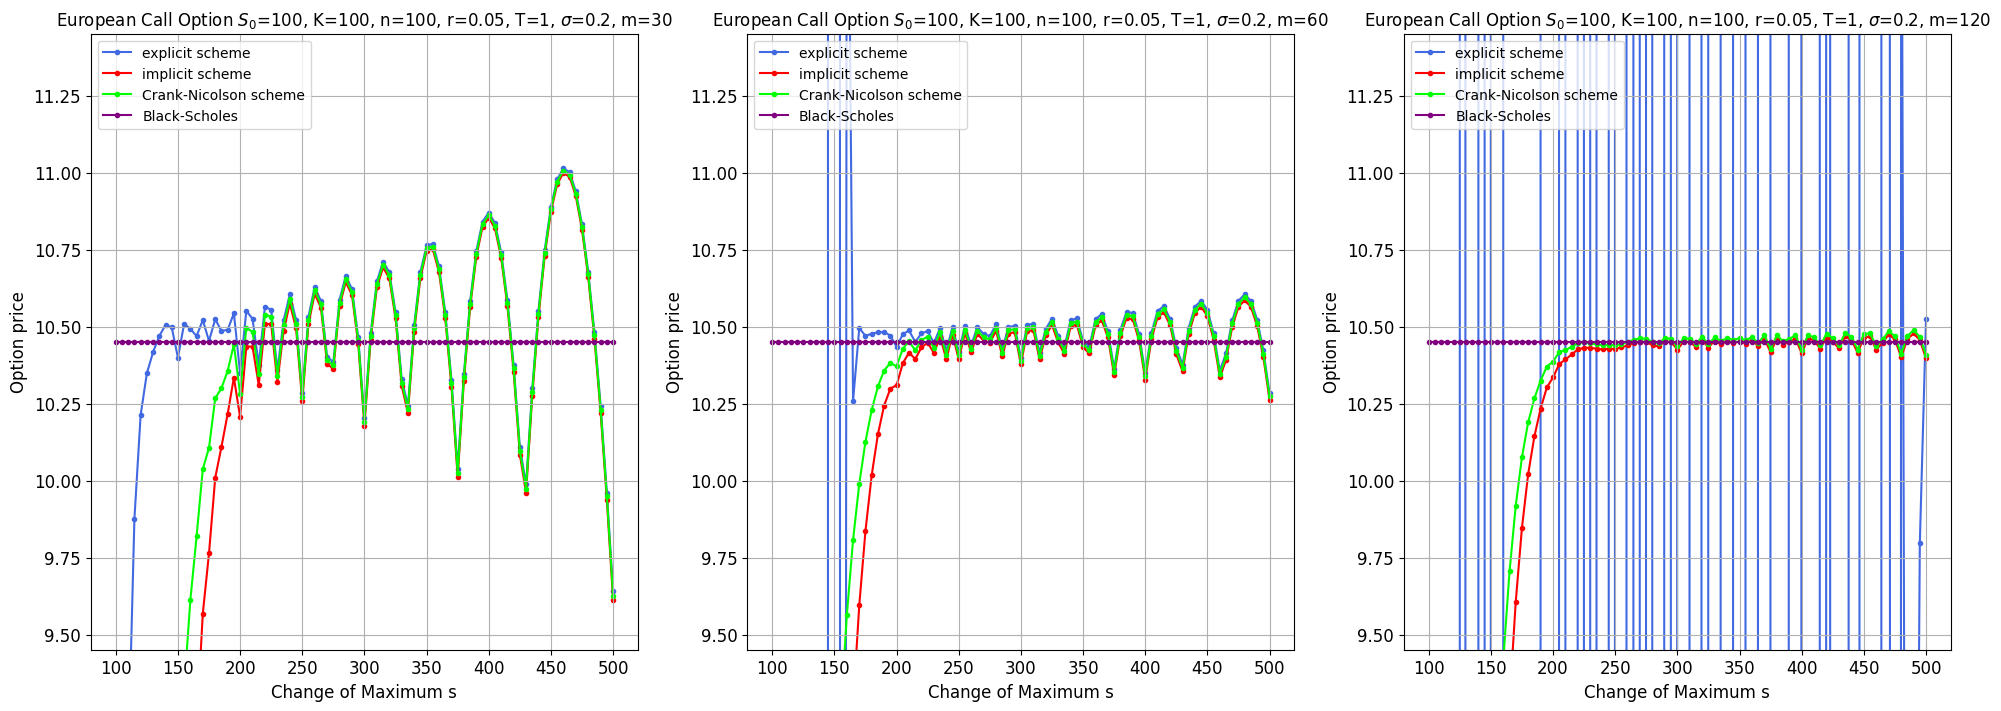

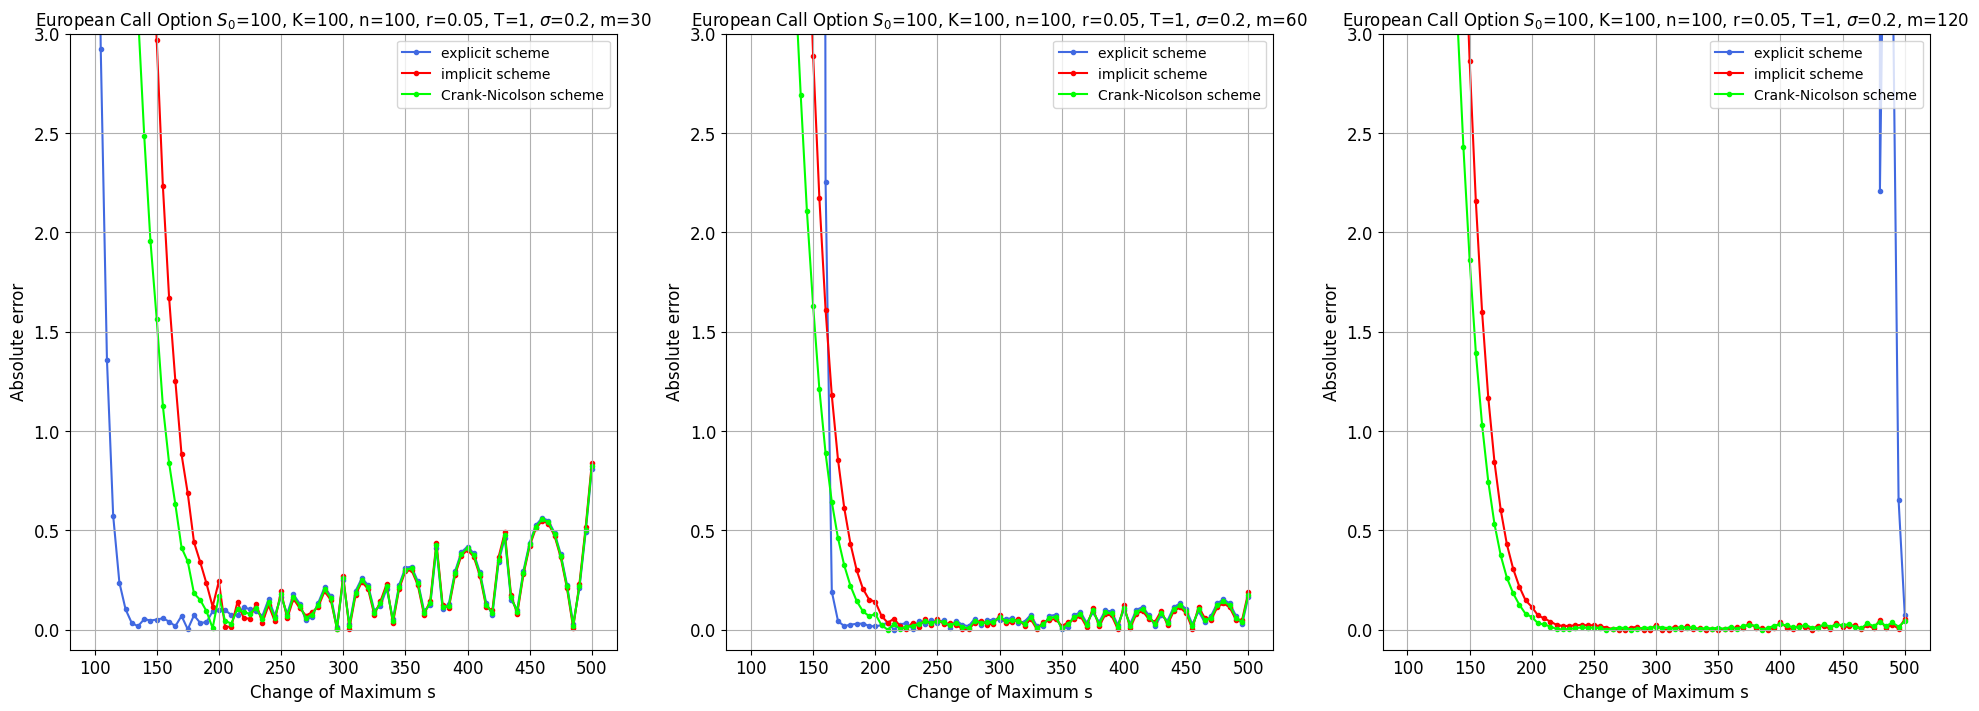

    Maximum s  Explicit, m=30  Implicit, m=30  Crank-Nicolson, m=30  Explicit, m=60  Implicit, m=60  Crank-Nicolson, m=60  Explicit, m=120  Implicit, m=120  Crank-Nicolson, m=120
0         100        5.573526        5.573526              5.573526    5.573526e+00        5.573526              5.573526     5.573526e+00         5.573526               5.573526
1         105        2.923348       10.442556              6.812431    2.274155e+15       10.442313              7.111905     7.368281e+94        10.441726               7.704526
2         110        1.359105       10.335831              6.005063    1.042671e+14       10.330827              6.357417     2.248140e+93        10.330678               7.072191
3         115        0.574722        9.981761              5.450999    6.095240e+12        9.966459              5.812017     5.783861e+88         9.963436               6.566480
4         120        0.238206        9.296685              4.943298    8.428869e+11        9.271958      

In [9]:
n = 100
Smax = list(np.arange(100, 501, 5))
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'call')
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'call', True)

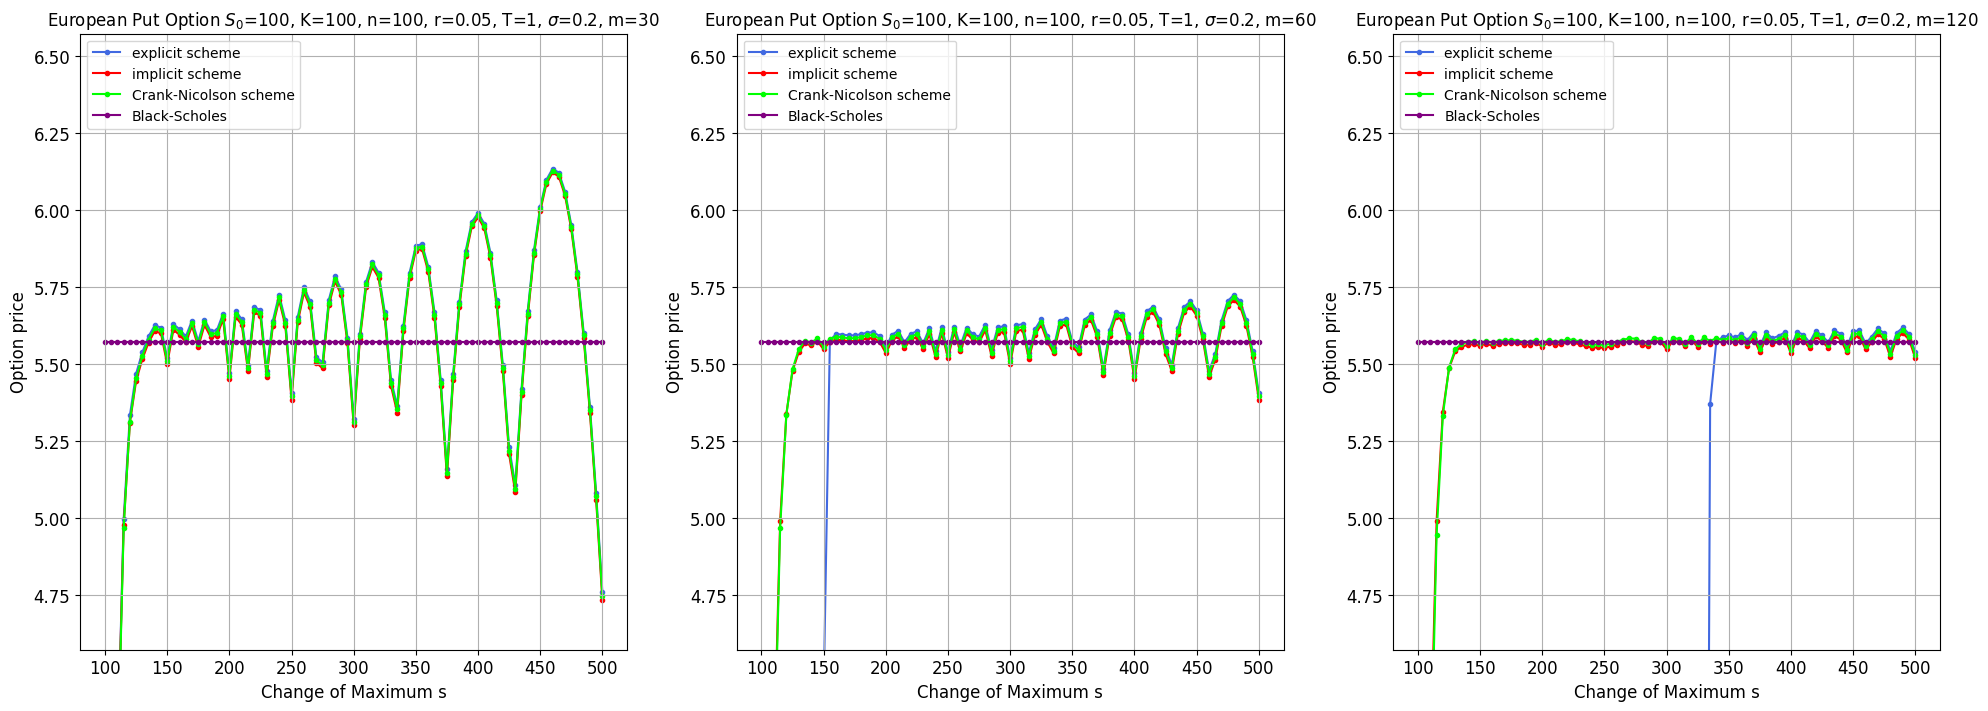

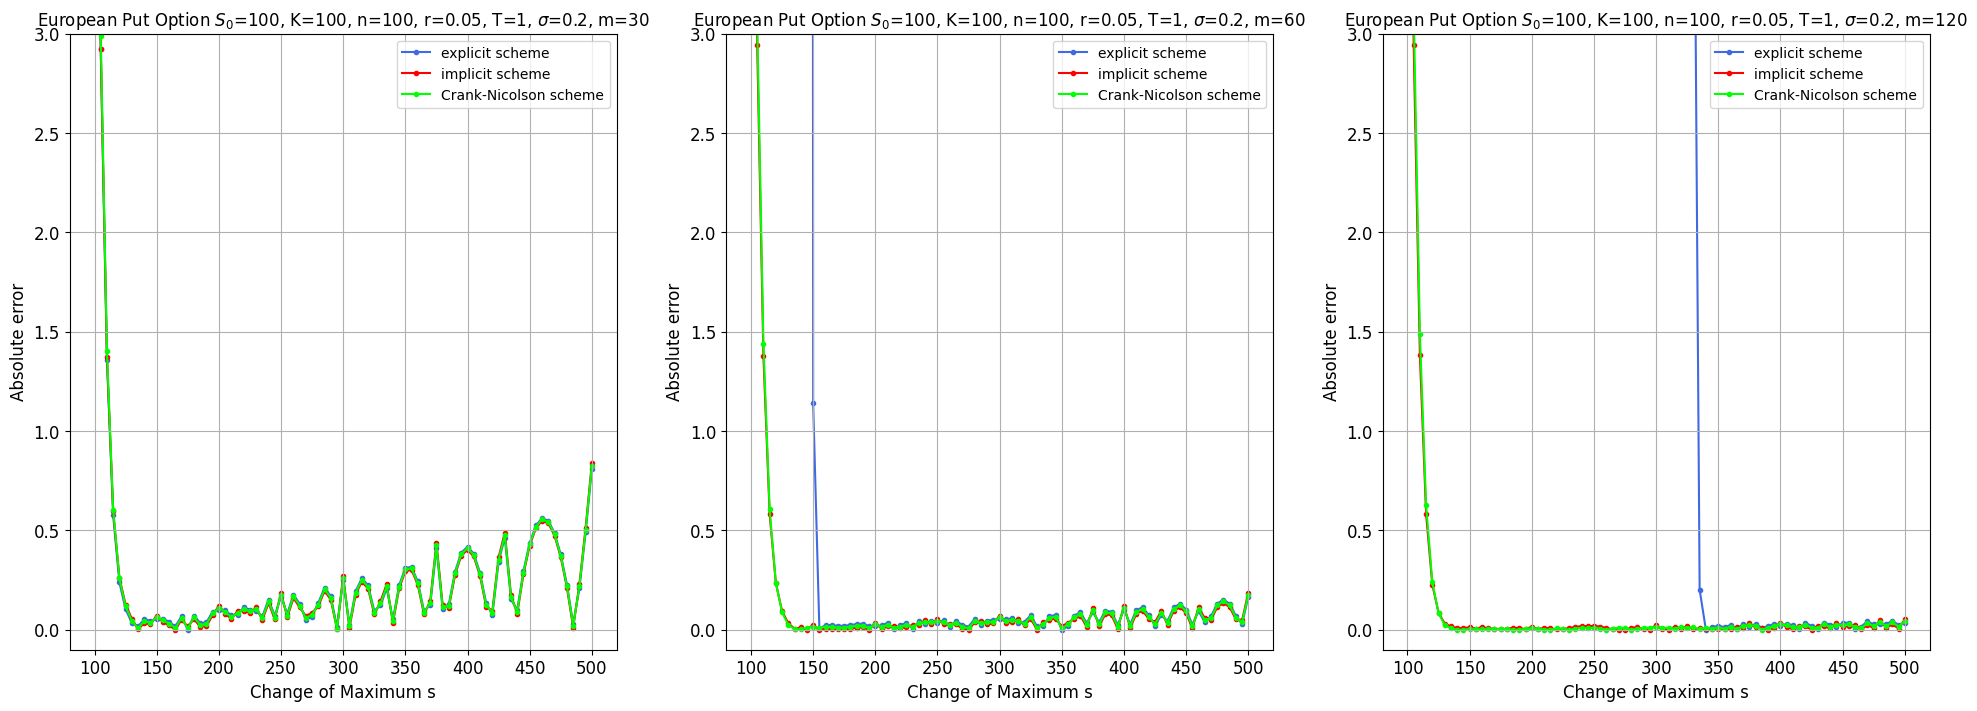

    Maximum s  Explicit, m=30  Implicit, m=30  Crank-Nicolson, m=30  Explicit, m=60  Implicit, m=60  Crank-Nicolson, m=60  Explicit, m=120  Implicit, m=120  Crank-Nicolson, m=120
0         100        5.573526        5.573526              5.573526    5.573526e+00        5.573526              5.573526     5.573526e+00         5.573526               5.573526
1         105        2.923711        2.925433              2.988480    2.274149e+15        2.942136              3.057963     7.368309e+94         2.942908               3.133233
2         110        1.359733        1.371376              1.402527    1.042658e+14        1.376818              1.438574     2.248090e+93         1.381500               1.486496
3         115        0.575536        0.595991              0.604175    6.095600e+12        0.582369              0.606011     5.759194e+88         0.581173               0.626611
4         120        0.239148        0.263017              0.259115    8.430222e+11        0.234539      

In [10]:
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'put')
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'put', True)

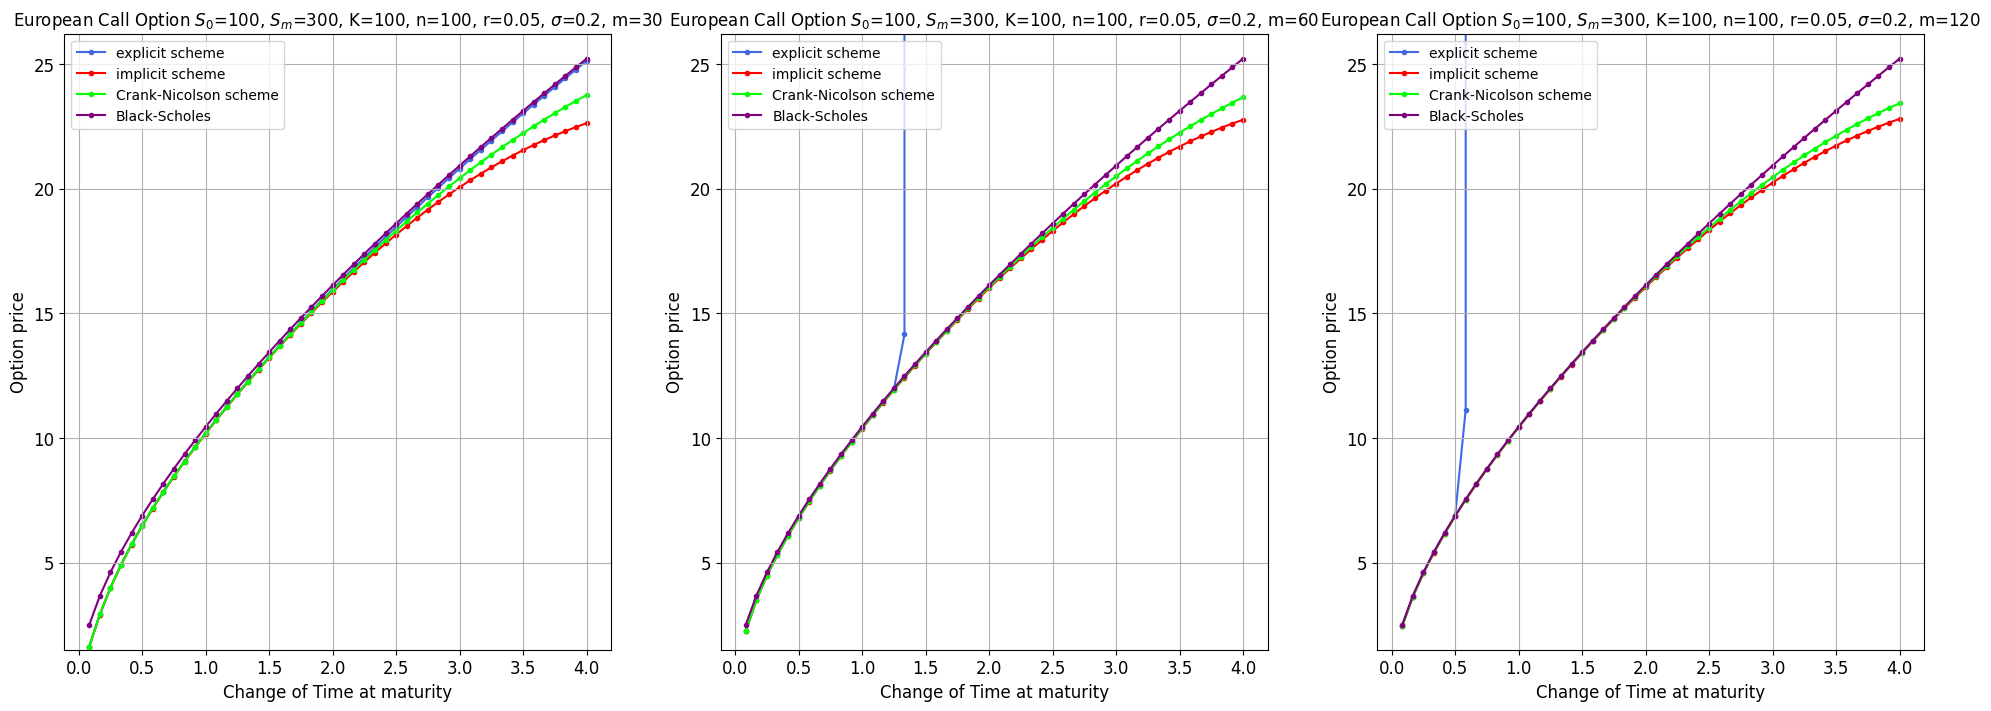

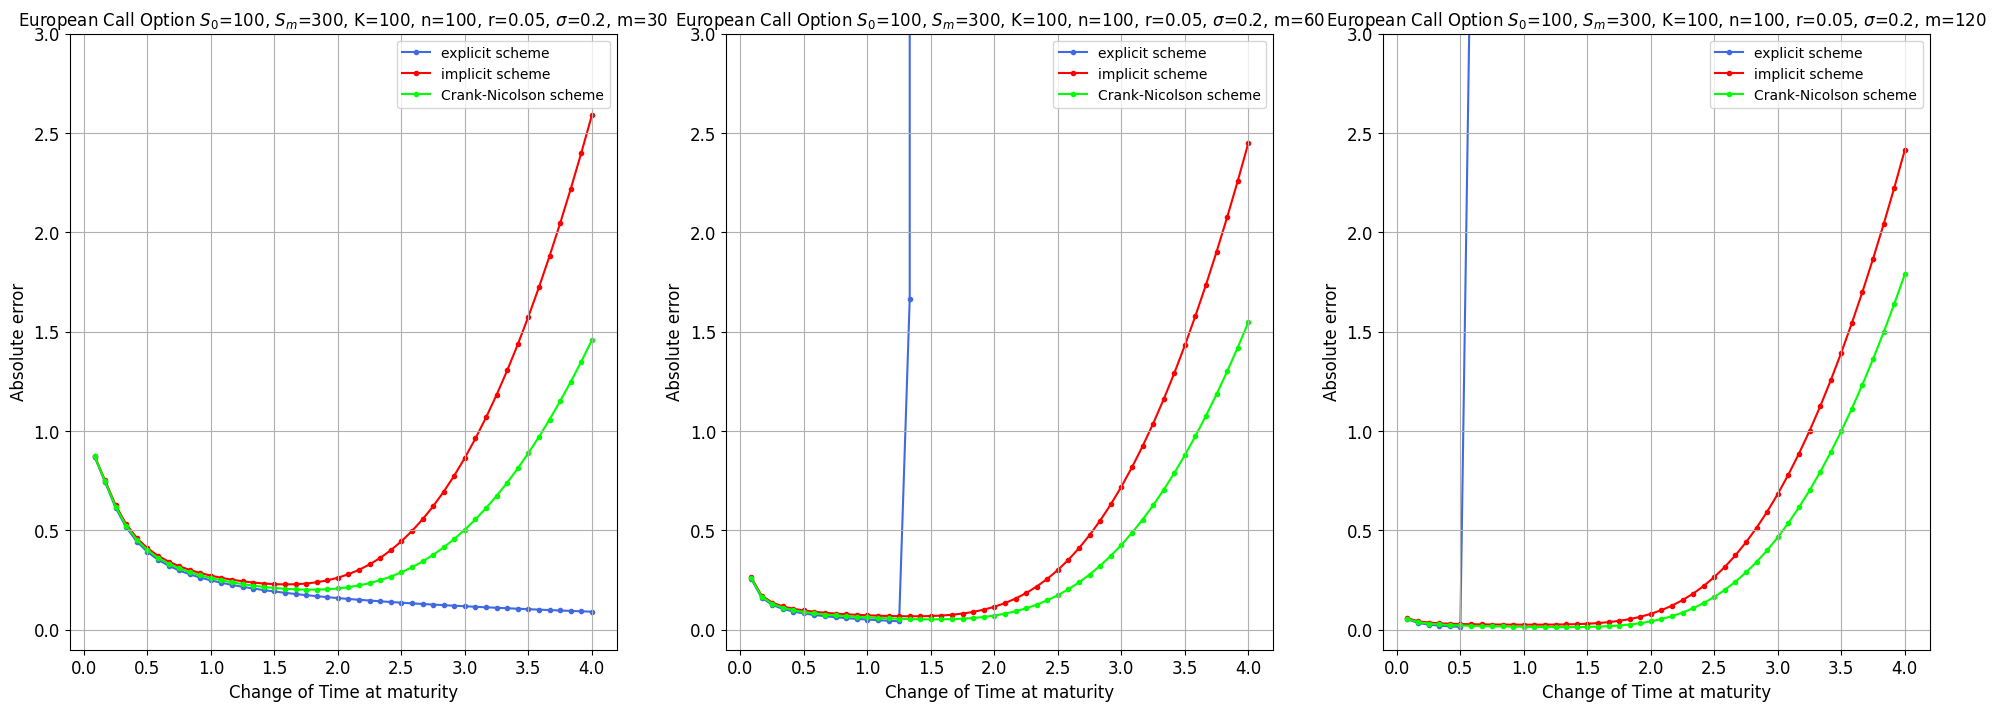

    Time at maturity  Explicit, m=30  Implicit, m=30  Crank-Nicolson, m=30  Explicit, m=60  Implicit, m=60  Crank-Nicolson, m=60  Explicit, m=120  Implicit, m=120  Crank-Nicolson, m=120
0           0.083333        0.872202        0.875617              0.873912    2.584226e-01        0.266279              0.262353     5.299168e-02         0.059263               0.056118
1           0.166667        0.742914        0.751618              0.747275    1.626145e-01        0.172714              0.167648     3.458659e-02         0.043063               0.038815
2           0.250000        0.613456        0.626403              0.619939    1.258614e-01        0.137208              0.131515     2.633801e-02         0.036607               0.031462
3           0.333333        0.515475        0.531295              0.523389    1.056496e-01        0.118279              0.111946     2.123952e-02         0.033060               0.027138
4           0.416667        0.444262        0.461940              0.45

In [11]:
n = 100
T, Smax = list(np.arange(1/12, 4.01, 1/12)), 300
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'call')
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'call', True)

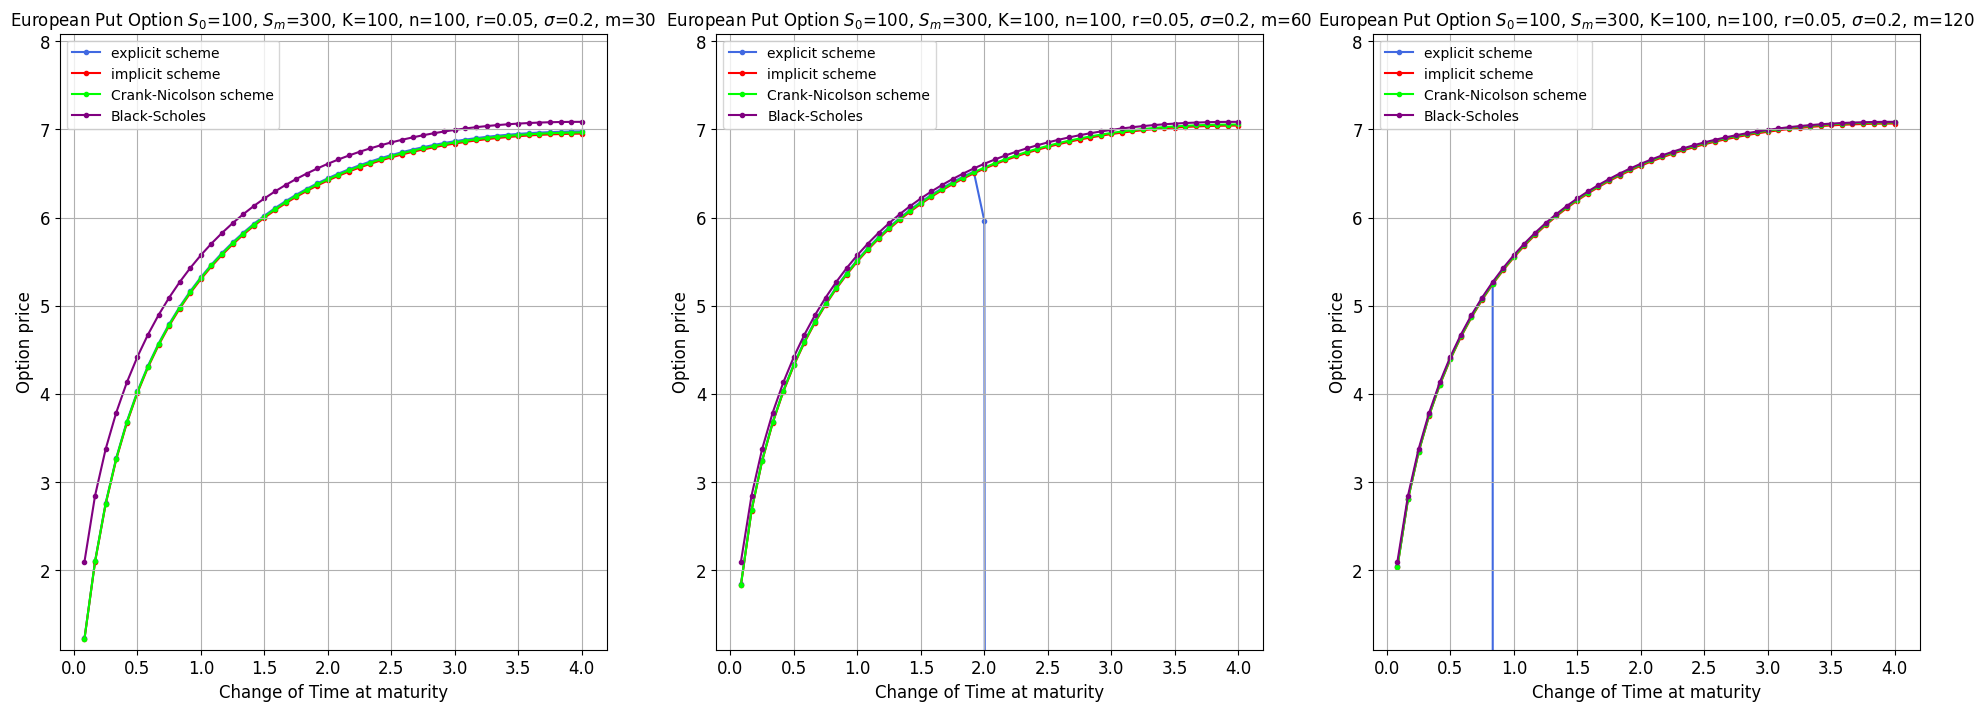

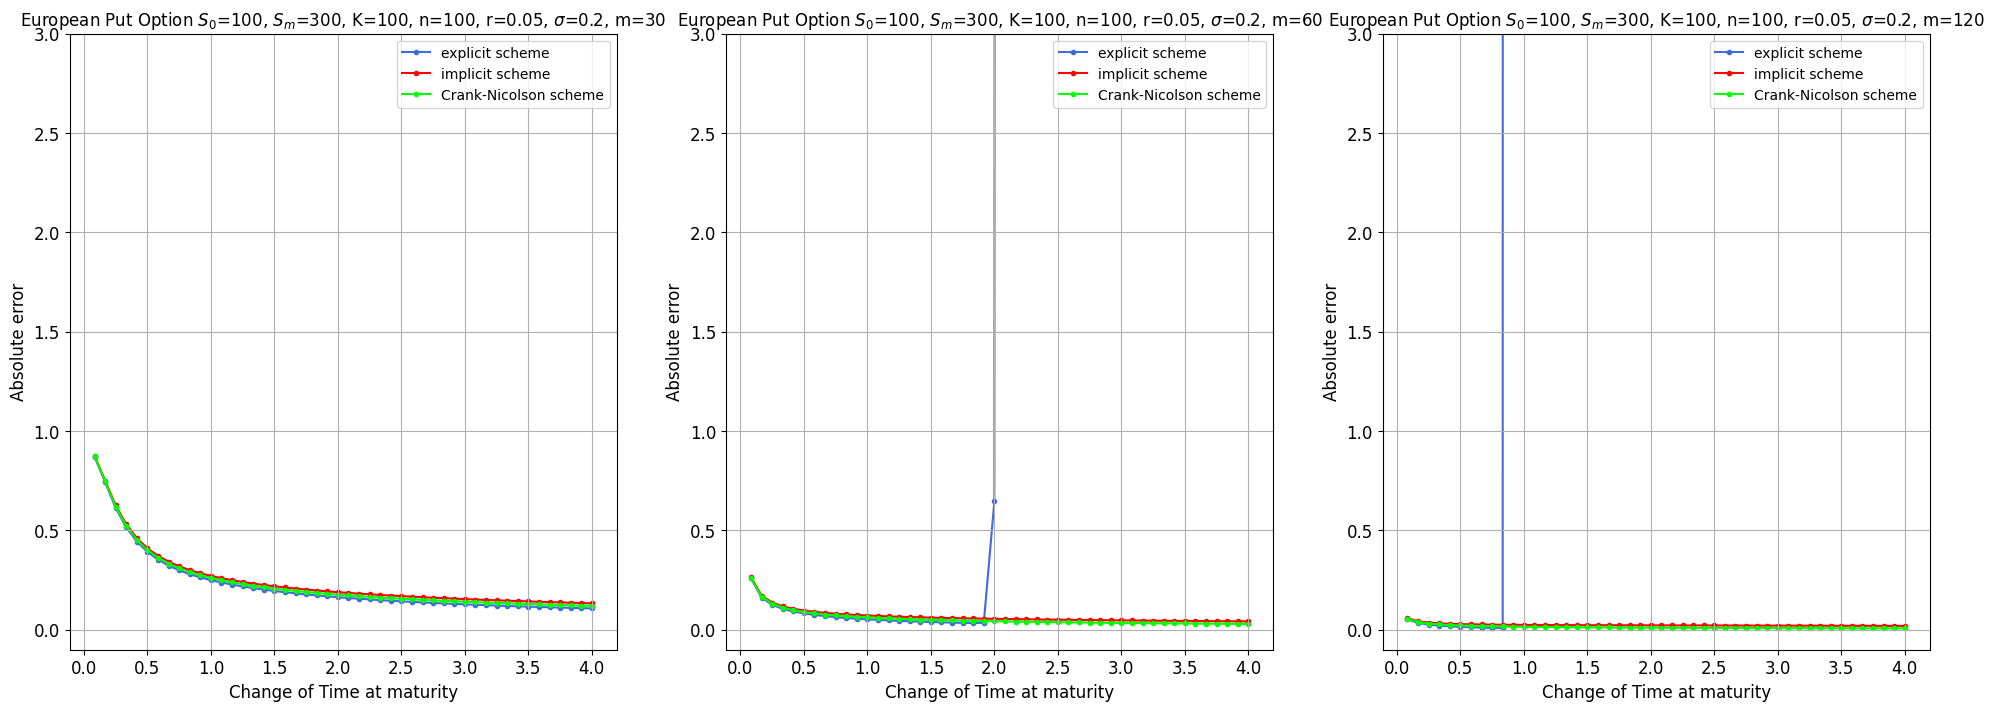

    Time at maturity  Explicit, m=30  Implicit, m=30  Crank-Nicolson, m=30  Explicit, m=60  Implicit, m=60  Crank-Nicolson, m=60  Explicit, m=120  Implicit, m=120  Crank-Nicolson, m=120
0           0.083333        0.872210        0.875608              0.873912    2.584313e-01        0.266271              0.262353     5.300033e-02         0.059255               0.056118
1           0.166667        0.742948        0.751583              0.747275    1.626490e-01        0.172680              0.167648     3.462102e-02         0.043029               0.038815
2           0.250000        0.613533        0.626326              0.619939    1.259386e-01        0.137131              0.131515     2.641517e-02         0.036530               0.031462
3           0.333333        0.515611        0.531159              0.523389    1.057862e-01        0.118143              0.111946     2.137612e-02         0.032923               0.027138
4           0.416667        0.444474        0.461728              0.45

In [12]:
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'put')
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'put', True)

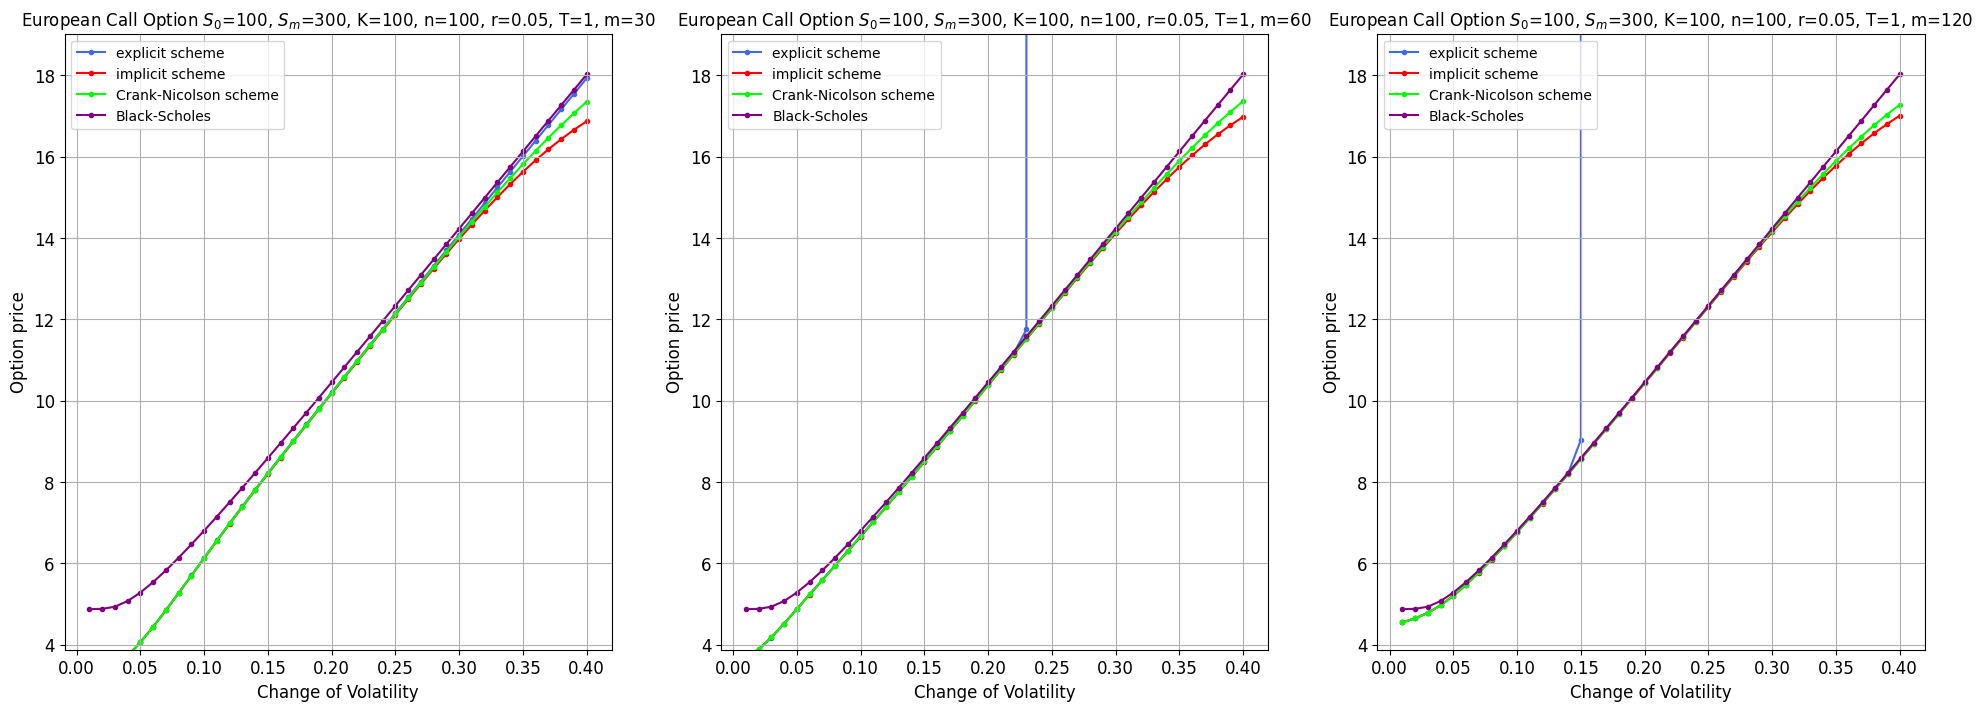

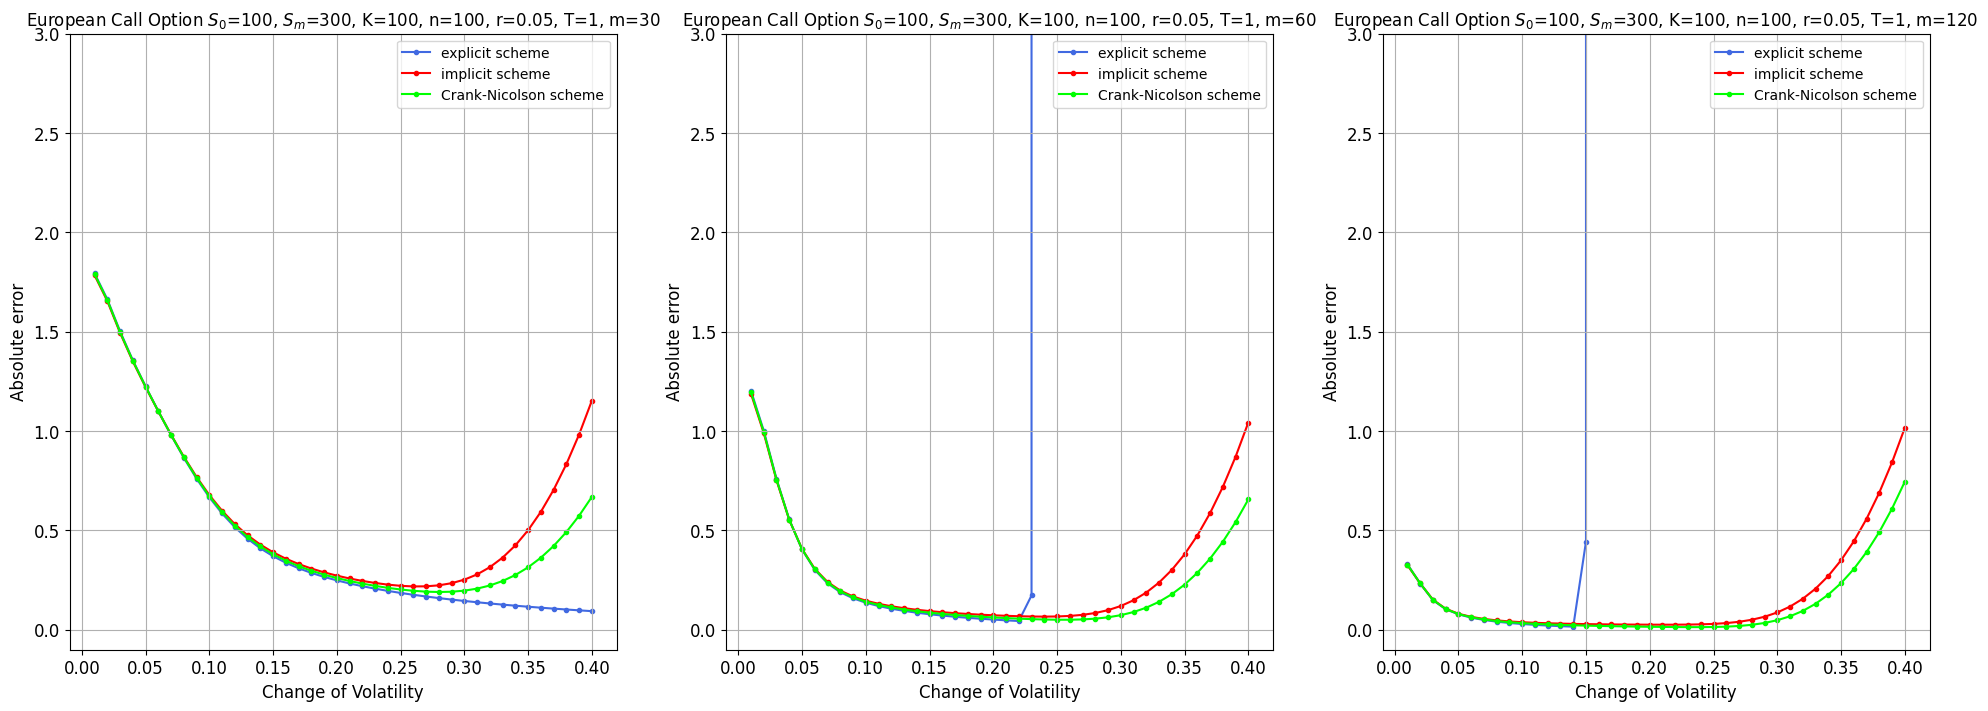

    Volatility  Explicit, m=30  Implicit, m=30  Crank-Nicolson, m=30  Explicit, m=60  Implicit, m=60  Crank-Nicolson, m=60  Explicit, m=120  Implicit, m=120  Crank-Nicolson, m=120
0         0.01        1.794476        1.785013              1.789737    1.203398e+00        1.188218              1.195770     3.301128e-01         0.325432               0.327695
1         0.02        1.664152        1.655308              1.659722    1.002274e+00        0.990440              0.996324     2.330197e-01         0.233588               0.233299
2         0.03        1.503007        1.495281              1.499136    7.599325e-01        0.752930              0.756408     1.493039e-01         0.151669               0.150496
3         0.04        1.357540        1.351501              1.354512    5.554163e-01        0.553536              0.554468     1.037941e-01         0.106168               0.104974
4         0.05        1.225909        1.222144              1.224020    4.050220e-01        0.407400

In [13]:
sigma, T = list(np.arange(0.01, 0.41, 0.01)), 1
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'call')
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'call', True)

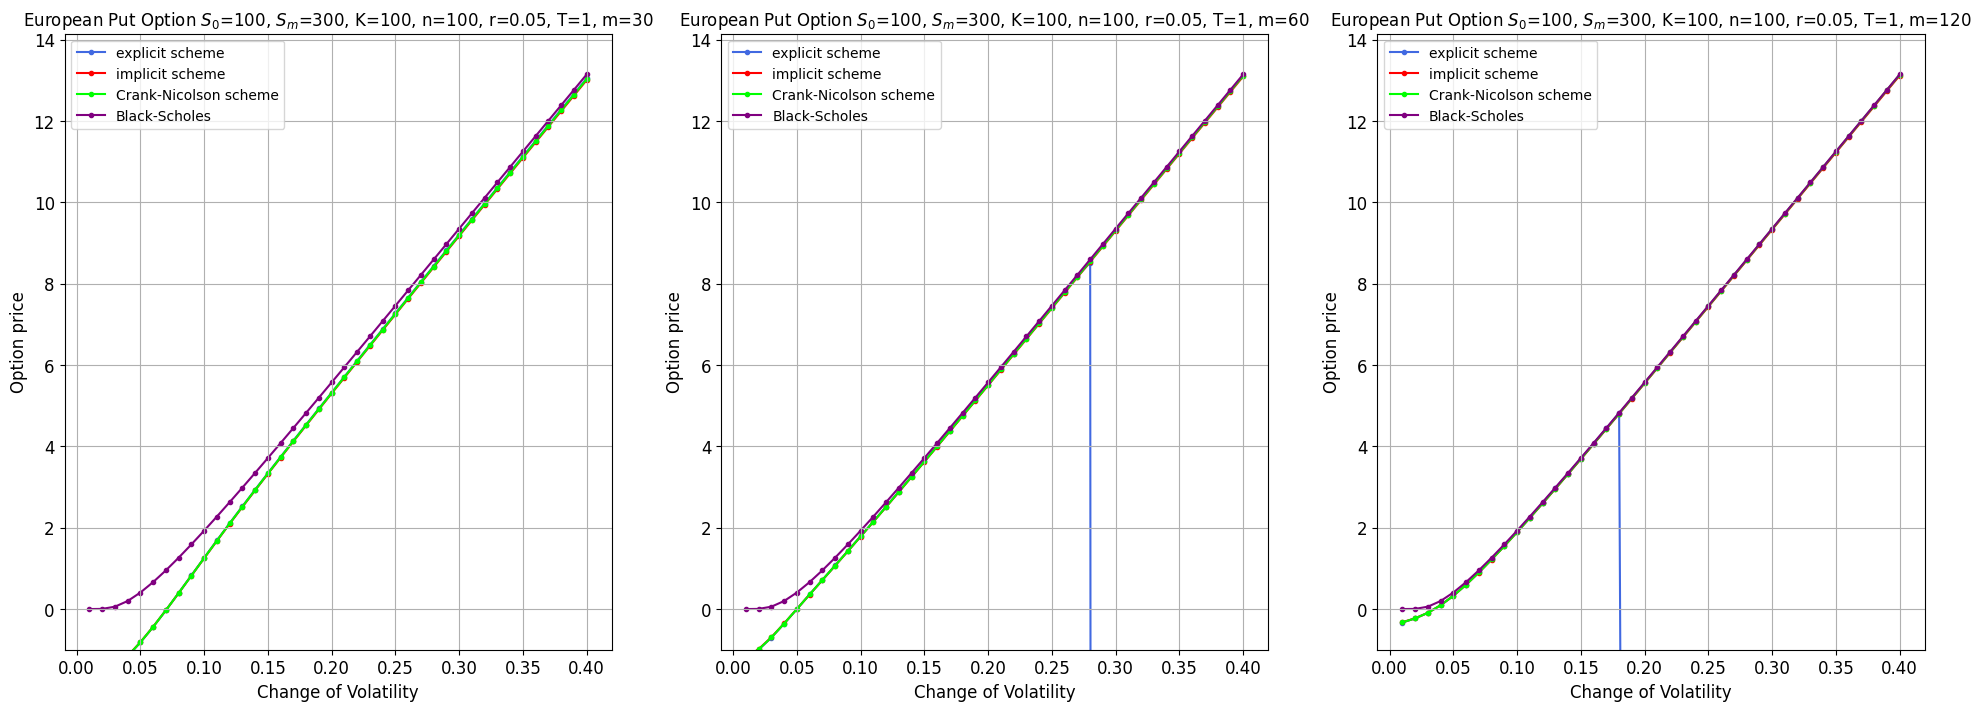

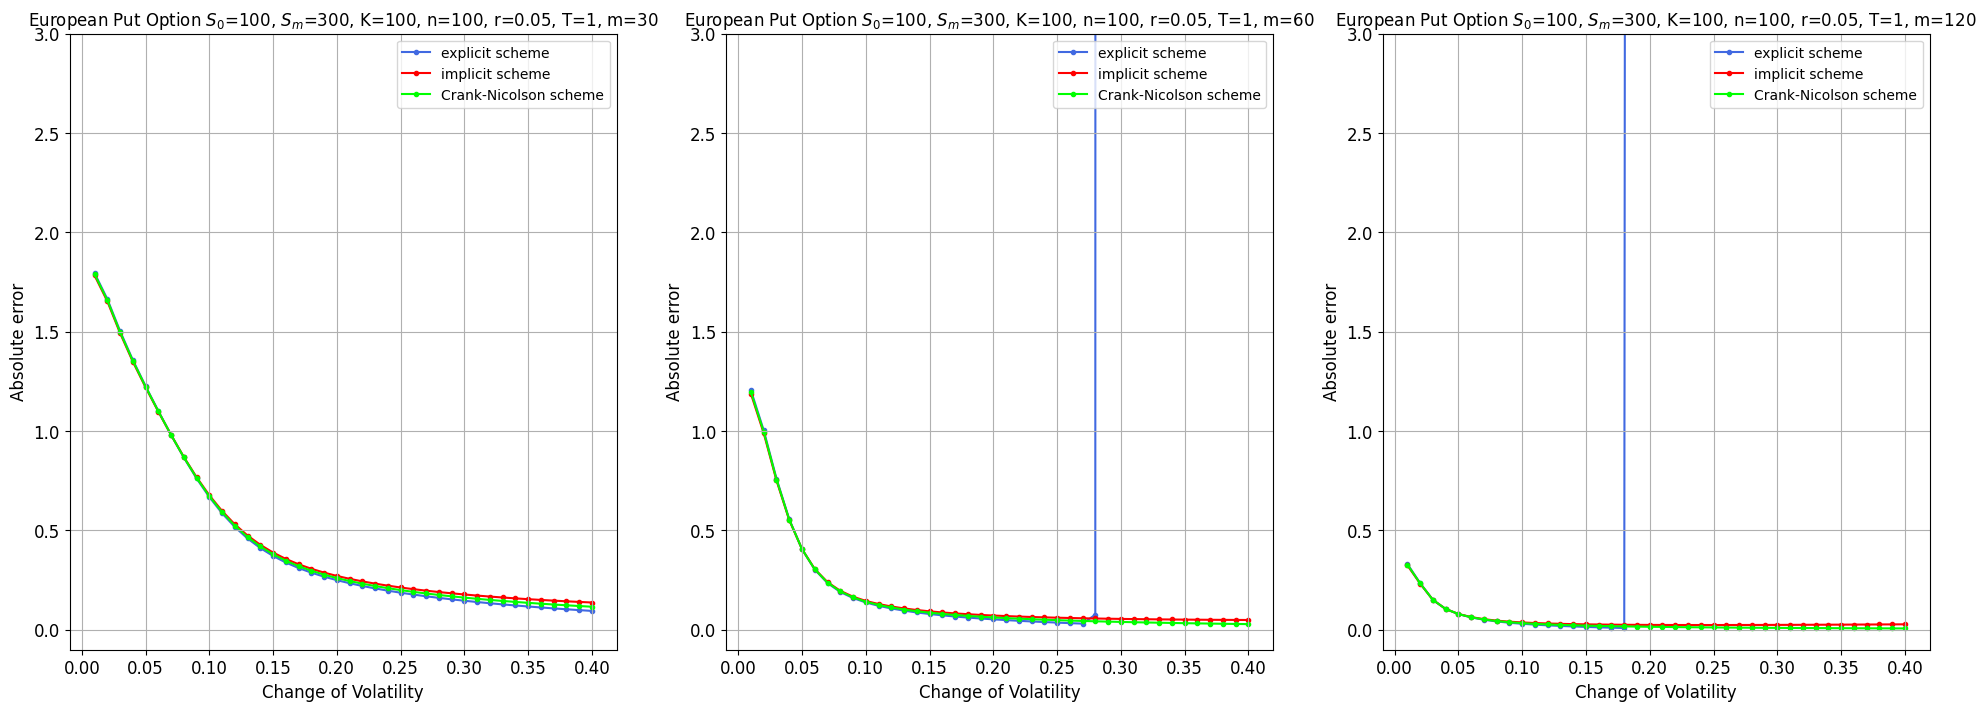

    Volatility  Explicit, m=30  Implicit, m=30  Crank-Nicolson, m=30  Explicit, m=60  Implicit, m=60  Crank-Nicolson, m=60  Explicit, m=120  Implicit, m=120  Crank-Nicolson, m=120
0         0.01        1.795666        1.783825              1.789738    1.204587e+00        1.187029              1.195770     3.313022e-01         0.324244               0.327695
1         0.02        1.665341        1.654119              1.659722    1.003463e+00        0.989252              0.996324     2.342092e-01         0.232400               0.233299
2         0.03        1.504197        1.494092              1.499136    7.611219e-01        0.751741              0.756408     1.504933e-01         0.150480               0.150497
3         0.04        1.358729        1.350313              1.354512    5.566057e-01        0.552348              0.554468     1.049835e-01         0.104980               0.104974
4         0.05        1.227099        1.220955              1.224020    4.062114e-01        0.406211

In [14]:
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'put')
option_price_change(S0, Smax, K, r, T, sigma, n, ms, 'put', True)

time

In [15]:
def option_price_time_method(S0, Smax, K, r, T, sigma, ns, ms, option_type, method):
    total = []
    for i in range(len(ms)):
        m = []
        for n in ns:
            FDS = FiniteDifferenceScheme(S0, Smax, K, r, T, sigma, n, ms[i])
            t1 = time.time()
            FDS.price(option_type, method)
            t2 = time.time()
            m.append(t2-t1)
        total.append(sum(m))
    return total

In [16]:
S0 = 100
Smax = 300
sigma = 0.2
r = 0.05
T = 1
K = 100

In [17]:
ns = np.arange(3, 101, 1)
ms = [3, 30, 60, 120]

In [18]:
data1 = [
    option_price_time_method(S0, Smax, K, r, T, sigma, ns, ms, 'call', 'explicit'),
    option_price_time_method(S0, Smax, K, r, T, sigma, ns, ms, 'call', 'implicit'),
    option_price_time_method(S0, Smax, K, r, T, sigma, ns, ms, 'call', 'cn')
]
columns = ["m=3", "m=30", "m=60", "m=120"]
df1 = pd.DataFrame(data1, columns=columns)
df1.insert(0, "method", ['explicit', 'implicit', 'Crank-Nicolson'])
df1

,method,m=3,m=30,m=60,m=120
0,explicit,0.031991,0.141509,0.268981,0.530985
1,implicit,0.032000,0.057001,0.069997,0.463986
2,Crank-Nicolson,0.016001,0.019998,0.026000,0.035008


In [19]:
data2 = [
    option_price_time_method(S0, Smax, K, r, T, sigma, ns, ms, 'put', 'explicit'),
    option_price_time_method(S0, Smax, K, r, T, sigma, ns, ms, 'put', 'implicit'),
    option_price_time_method(S0, Smax, K, r, T, sigma, ns, ms, 'put', 'cn')
]
df2 = pd.DataFrame(data2, columns=columns)
df2.insert(0, "method", ['explicit', 'implicit', 'Crank-Nicolson'])
df2

,method,m=3,m=30,m=60,m=120
0,explicit,0.031998,0.142995,0.268003,0.563000
1,implicit,0.029973,0.089997,0.068999,0.402987
2,Crank-Nicolson,0.015999,0.020000,0.023999,0.033009
